In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# PCA and EigenFaces Demo

In this demo, we will go through the basic concepts behind the principal component analysis (PCA).  We will then apply PCA to a face dataset to find the characteristic faces ("eigenfaces").

## What is PCA?

PCA is a **linear** transformation. Suppose we have a $N \times P$ data matrix ${\bf X}$, where $N$ is the number of samples and $P$ is the dimension of each sample.  Then PCA will find you a $K \times P$ matrix ${\bf V}$ such that

$$ \underbrace{{\bf X}}_{N \times P} = \underbrace{{\bf S}}_{P \times K} \underbrace{{\bf V}}_{K \times P}. $$

Here, $K$ is the number of **principal components** with $K \le P$.

## But what does the V matrix do?

We can think of ${\bf V}$ in many different ways.

The first way is to think of it as a de-correlating transformation:  originally, each variable (or dimension) in ${\bf X}$ - there are $P$ of them - may be *correlated*.  That is, if we take any two column vectors of ${\bf X}$, say ${\bf x}_0$ and ${\bf x}_1$, their covariance is not going to be zero.

Let's try this in a randomly generated data:

In [3]:
from numpy.random import standard_normal  # Gaussian variables
N = 1000; P = 5
X = standard_normal((N, P))
W = X - X.mean(axis=0,keepdims=True)
print(dot(W[:,0], W[:,1]))

-19.2165045118


I'll skip ahead and use a pre-canned PCA routine from `scikit-learn` (but we'll dig into it a bit later!) Let's see what happens to the transformed variables, ${\bf S}$:

In [4]:
from sklearn.decomposition import PCA
S=PCA(whiten=True).fit_transform(X)
print(dot(S[:,0], S[:,1]))

-3.87245790989e-13


Another way to look at ${\bf V}$ is to think of them as **projections**.  Since the row vectors of ${\bf V}$ is *orthogonal* to each other, the projected data ${\bf S}$ lines in a new "coordinate system" specified by ${\bf V}$. Furthermore, the new coordinate system is sorted in the decreasing order of *variance* in the original data. So, PCA can be thought of as calculating a new coordinate system where the basis vectors point toward the direction of largest variances first.

<img src="files/images/PCA/pca.png" style="margin:auto; width: 483px;"/>

Exercise 1. Let's get a feel for this in the following interactive example.  Try moving the sliders around to generate the data, and see how the principal component vectors change.

In this demo, `mu_x` and `mu_y` specifies the center of the data, `sigma_x` and `sigma_y` the standard deviations, and everything is rotated by the angle `theta`.  The two blue arrows are the rows of ${\bf V}$ that gets calculated.

When you click on `center`, the data is first centered (mean is subtracted from the data) first.  (Question: why is it necessary to "center" data when `mu_x` and `mu_y` are not zero?)

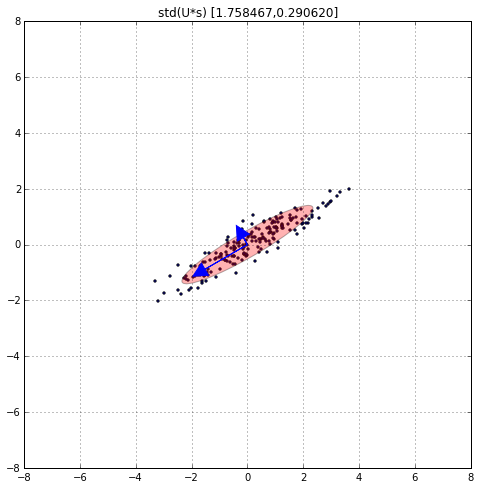

In [5]:
from numpy.random import standard_normal
from matplotlib.patches import Ellipse
from numpy.linalg import svd
@interact
def plot_2d_pca(mu_x=FloatSlider(min=-3.0, max=3.0, value=0), 
                mu_y=FloatSlider(min=-3.0, max=3.0, value=0), 
                sigma_x=FloatSlider(min=0.2, max=1.8, value=1.8),
                sigma_y=FloatSlider(min=0.2, max=1.8, value=0.3),
                theta=FloatSlider(min=0.0, max=pi, value=pi/6), center=False):
    mu=array([mu_x, mu_y])
    sigma=array([sigma_x, sigma_y])
    R=array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])
    X=dot(standard_normal((1000, 2)) * sigma[newaxis,:],R.T) + mu[newaxis,:]

    # Plot the points and the ellipse
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X[:200,0], X[:200,1], marker='.')
    ax.grid()
    M=8.0
    ax.set_xlim([-M,M])
    ax.set_ylim([-M,M])
    e=Ellipse(xy=array([mu_x, mu_y]), width=sigma_x*3, height=sigma_y*3, angle=theta/pi*180, 
              facecolor=[1.0,0,0], alpha=0.3)
    ax.add_artist(e)
    
    # Perform PCA and plot the vectors
    if center:
        X_mean=X.mean(axis=0,keepdims=True)
    else:
        X_mean=zeros((1,2))

    # Doing PCA here... I'm using svd instead of scikit-learn PCA, we'll come back to this.
    U,s,V =svd(X-X_mean, full_matrices=False)
    for v in dot(diag(s/sqrt(X.shape[0])),V): # Each eigenvector
        ax.arrow(X_mean[0,0],X_mean[0,1],-v[0],-v[1], 
                head_width=0.5, head_length=0.5, fc='b', ec='b')
        Ustd=U.std(axis=0)
        ax.set_title('std(U*s) [%f,%f]' % (Ustd[0]*s[0],Ustd[1]*s[1]))


Yet another use for ${\bf V}$ is to perform a **dimensionality reduction**.  In many scenarios you encounter in image manipulation (as we'll see soon), we might want to have a more concise representation of the data ${\bf X}$.  PCA with $K < P$ is one way to *reduce the dimesionality*: because PCA picks the directions with highest data variances, if a small number of top $K$ rows are sufficient to approximate (reconstruct) ${\bf X}$.

## How do we actually *perform* PCA?

Well, we can use `from sklearn.decomposition import PCA`.  But for learning, let's dig just one step into what it acutally does.

One of the easiest way to perform PCA is to use the singular value decomposition (SVD).  SVD decomposes a matrix ${\bf X}$ into a unitary matrix ${\bf U}$, rectangular diagonal matrix ${\bf \Sigma}$ (called "singular values"),  and another unitary matrix ${\bf W}$ such that

$$ {\bf X} = {\bf U} {\bf \Sigma} {\bf W}$$

So how can we use that to do PCA? Well, it turns out ${\bf \Sigma} {\bf W}$ of SVD, are exactly what we need to calculate the ${\bf V}$ matrix for the PCA, so we just have to run SVD and set ${\bf V} = {\bf \Sigma} {\bf W}$.

(Note: `svd` of `numpy` returns only the diagonal elements of ${\bf \Sigma}$.)

Exercise 2.  Generate 1000 10-dimensional data and perform PCA this way.  Plot the squares of the singular values.

To reduce the the $P$-dimesional data ${\bf X}$ to a $K$-dimensional data, we just need to pick the top $K$ row vectors of ${\bf V}$ - let's call that ${\bf W}$ - then calcuate ${\bf T} = {\bf X} {\bf W}^\intercal$.  ${\bf T}$ then has the dimension $N \times K$.

If we want to reconstruct the data ${\bf T}$, we simply do ${\hat {\bf X}} = {\bf T} {\bf W}$ (and re-add the means for ${\bf X}$, if necessary).

Exercise 3.  Reduce the same data to 5 dimensions, then based on the projected data ${\bf T}$, reconstruct ${\bf X}$.  What's the mean squared error of the reconstruction?

# Performing PCA on a face dataset

Now that we have a handle on the PCA method, let's try applying it to a dataset consisting of face data.  We have two datasets in this demo, CAFE and POFA.  The following code loads the dataset into the `dataset` variable:

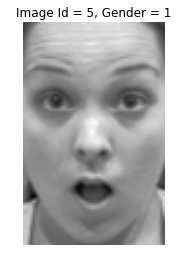

In [6]:
import pickle
dataset=pickle.load(open('data/cafe.pkl','r')) # or 'pofa.pkl' for POFA
disp('dataset.images shape is %s' % str(dataset.images.shape))
disp('dataset.data shape is %s' % str(dataset.data.shape))

@interact
def plot_face(image_id=(0, dataset.images.shape[0]-1)):
    plt.imshow(dataset.images[image_id],cmap='gray')
    plt.title('Image Id = %d, Gender = %d' % (dataset.target[image_id], dataset.gender[image_id]))
    plt.axis('off')

## Preprocessing

We'll center the data by subtracting the mean.  The first axis (`axis=0`) is the `n_samples` dimension.

In [7]:
X=dataset.data.copy() # So that we won't mess up the data in the dataset\
X_mean=X.mean(axis=0,keepdims=True) # Mean for each dimension across sample (centering)
X_std=X.std(axis=0,keepdims=True)
X-=X_mean
disp(all(abs(X.mean(axis=0))<1e-12)) # Are means for all dimensions very close to zero?

True


Then we perform SVD to calculate the projection matrix $V$.  By default, `U,s,V=svd(...)` returns full matrices, which will return $n \times n$ matrix `U`, $n$-dimensional vector of singular values `s`, and $d \times d$ matrix `V`.   But here, we don't really need $d \times d$ matrix `V`; with `full_matrices=False`, `svd` only returns $n \times d$ matrix for `V`.

In [8]:
from numpy.linalg import svd
U,s,V=svd(X,compute_uv=True, full_matrices=False)
disp(str(U.shape))
disp(str(s.shape))
disp(str(V.shape))

(80, 80)
(80,)
(80, 5700)


We can also plot how much each eigenvector in `V` contributes to the overall variance by plotting `variance_ratio` = $\frac{s^2}{\sum s^2}$.  (Notice that `s` is already in the decreasing order.)  The `cumsum` (cumulative sum) of `variance_ratio` then shows how much of the variance is explained by components up to `n_components`. 

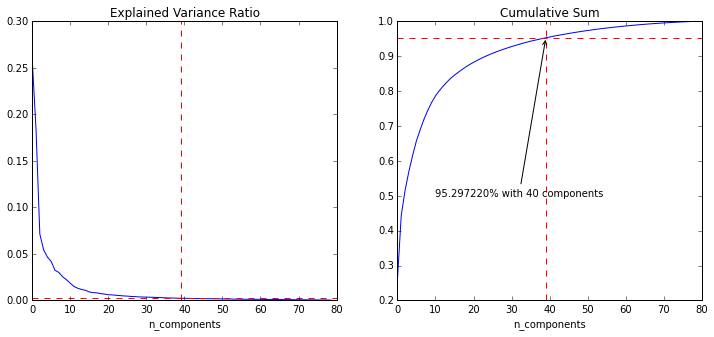

In [9]:
variance_ratio=s**2/(s**2).sum()   # Normalized so that they add to one.
@interact
def plot_variance_ratio(n_components=(1, len(variance_ratio))):
    n=n_components-1
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(variance_ratio)
    axs[0].set_title('Explained Variance Ratio')
    axs[0].set_xlabel('n_components')
    axs[0].axvline(n, color='r', linestyle='--')
    axs[0].axhline(variance_ratio[n], color='r', linestyle='--')
    
    axs[1].plot(cumsum(variance_ratio))
    axs[1].set_xlabel('n_components')
    axs[1].set_title('Cumulative Sum')
    
    captured=cumsum(variance_ratio)[n]
    axs[1].axvline(n, color='r', linestyle='--')
    axs[1].axhline(captured, color='r', linestyle='--')
    axs[1].annotate(s='%f%% with %d components' % (captured * 100, n_components), xy=(n, captured), 
                    xytext=(10, 0.5), arrowprops=dict(arrowstyle="->")) 

Since we're dealing with face data, each row vector of ${\bf V}$ is called an "eigenface".  The first "eigenface" is the one that explains a lot of variances in the data, whereas the last one explains the least.

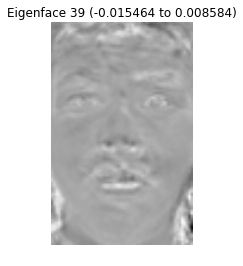

In [10]:
image_shape=dataset.images.shape[1:] # (H x W)
@interact
def plot_eigenface(eigenface=(0, V.shape[0]-1)):
    v=V[eigenface]*X_std
    
    plt.imshow(v.reshape(image_shape), cmap='gray')
    plt.title('Eigenface %d (%f to %f)' % (eigenface, v.min(), v.max()))
    plt.axis('off')

Now let's try reconstructing faces with different number of principal components (PCs)!  Now, the transformed `X` is reconstructed by multiplying by the sample standard deviations for each dimension and adding the sample mean. For this reason, even for zero components, you get a face-like image!

The rightmost plot is the "relative" reconstruction error (image minus the reconstruction squared, divided by the data standard deviations).  White is where the error is close to zero, and black is where the relative error is large (1 or more).  As you increase the number of PCs, you should see the error mostly going to zero (white).

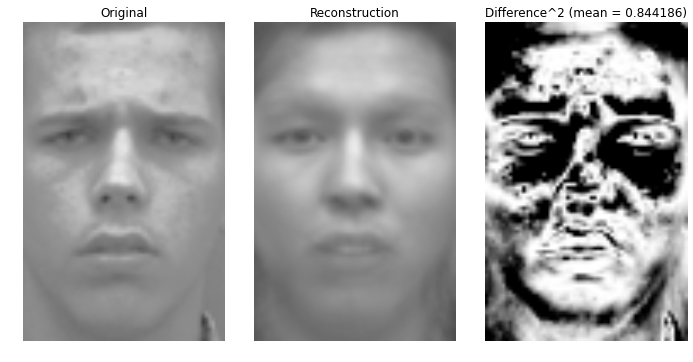

In [16]:
@interact
def plot_reconstruction(image_id=(0,dataset.images.shape[0]-1), n_components=(0, V.shape[0]-1),
                       pc1_multiplier=FloatSlider(min=-2,max=2, value=1)):
    # This is where we perform the projection and un-projection
    Vn=V[:n_components]
    M=ones(n_components)
    if n_components > 0:
        M[0]=pc1_multiplier
    X_hat=dot(multiply(dot(X[image_id], Vn.T), M), Vn)
    
    # Un-center
    I=X[image_id] + X_mean
    I_hat = X_hat + X_mean
    D=multiply(I-I_hat,I-I_hat) / multiply(X_std, X_std)
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(I.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Original')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Reconstruction')

    axs[2].imshow(1-D.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Difference^2 (mean = %f)' % sqrt(D.mean()))
    
    plt.tight_layout()

## Image morphing

As a fun exercise, we'll morph two images by taking averages of the two images within the transformed data space. How is it different than simply morphing them in the pixel space?

<function __main__.plot_morph>

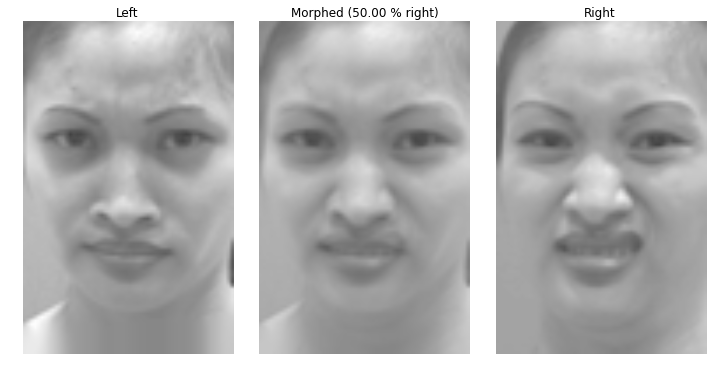

In [12]:
def plot_morph(left=0, right=1, mix=0.5):
    # Projected images
    x_lft=dot(X[left], V.T)
    x_rgt=dot(X[right], V.T)
    
    # Mix
    x_avg = x_lft * (1.0-mix) + x_rgt * (mix)
    
    # Un-project
    X_hat = dot(x_avg[newaxis,:], V)
    I_hat = X_hat + X_mean
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(dataset.images[left], cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Left')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Morphed (%.2f %% right)' % (mix * 100))

    axs[2].imshow(dataset.images[right], cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Right')
    
    plt.tight_layout()

interact(plot_morph,
         left=IntSlider(max=dataset.images.shape[0]-1),
         right=IntSlider(max=dataset.images.shape[0]-1,value=1),
         mix=FloatSlider(value=0.5, min=0, max=1.0))